In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Load data
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()

Train shape: (18524, 9)
Test shape: (6175, 8)


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


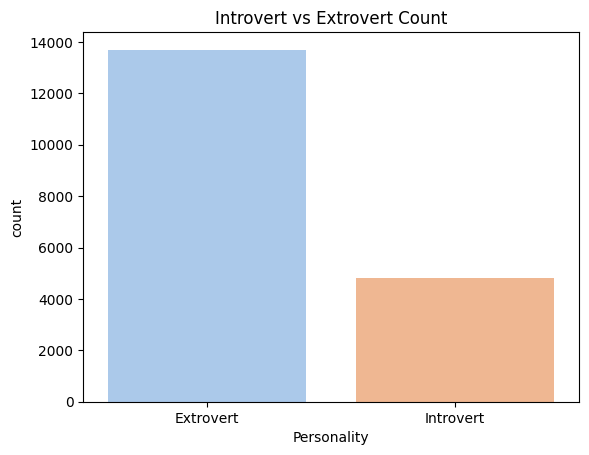

Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64


In [3]:
sns.countplot(x='Personality', data=train, palette='pastel')
plt.title("Introvert vs Extrovert Count")
plt.show()

print(train['Personality'].value_counts(normalize=True))

In [4]:
def data_overview(df):
    overview = pd.DataFrame({
        'Missing': df.isnull().sum(),
        'Missing %': df.isnull().mean() * 100,
        'Dtype': df.dtypes,
        'Unique': df.nunique()
    })
    return overview.sort_values(by='Missing', ascending=False)

data_overview(train)

,Missing,Missing %,Dtype,Unique
Stage_fear,1893,10.219175,object,2
Going_outside,1466,7.914057,float64,8
Post_frequency,1264,6.823580,float64,11
Time_spent_Alone,1190,6.424098,float64,12
Social_event_attendance,1180,6.370114,float64,11
Drained_after_socializing,1149,6.202764,object,2
Friends_circle_size,1054,5.689916,float64,16
id,0,0.000000,int64,18524
Personality,0,0.000000,object,2


In [5]:
le = LabelEncoder()
train['target'] = le.fit_transform(train['Personality'])  # Extrovert = 1, Introvert = 0

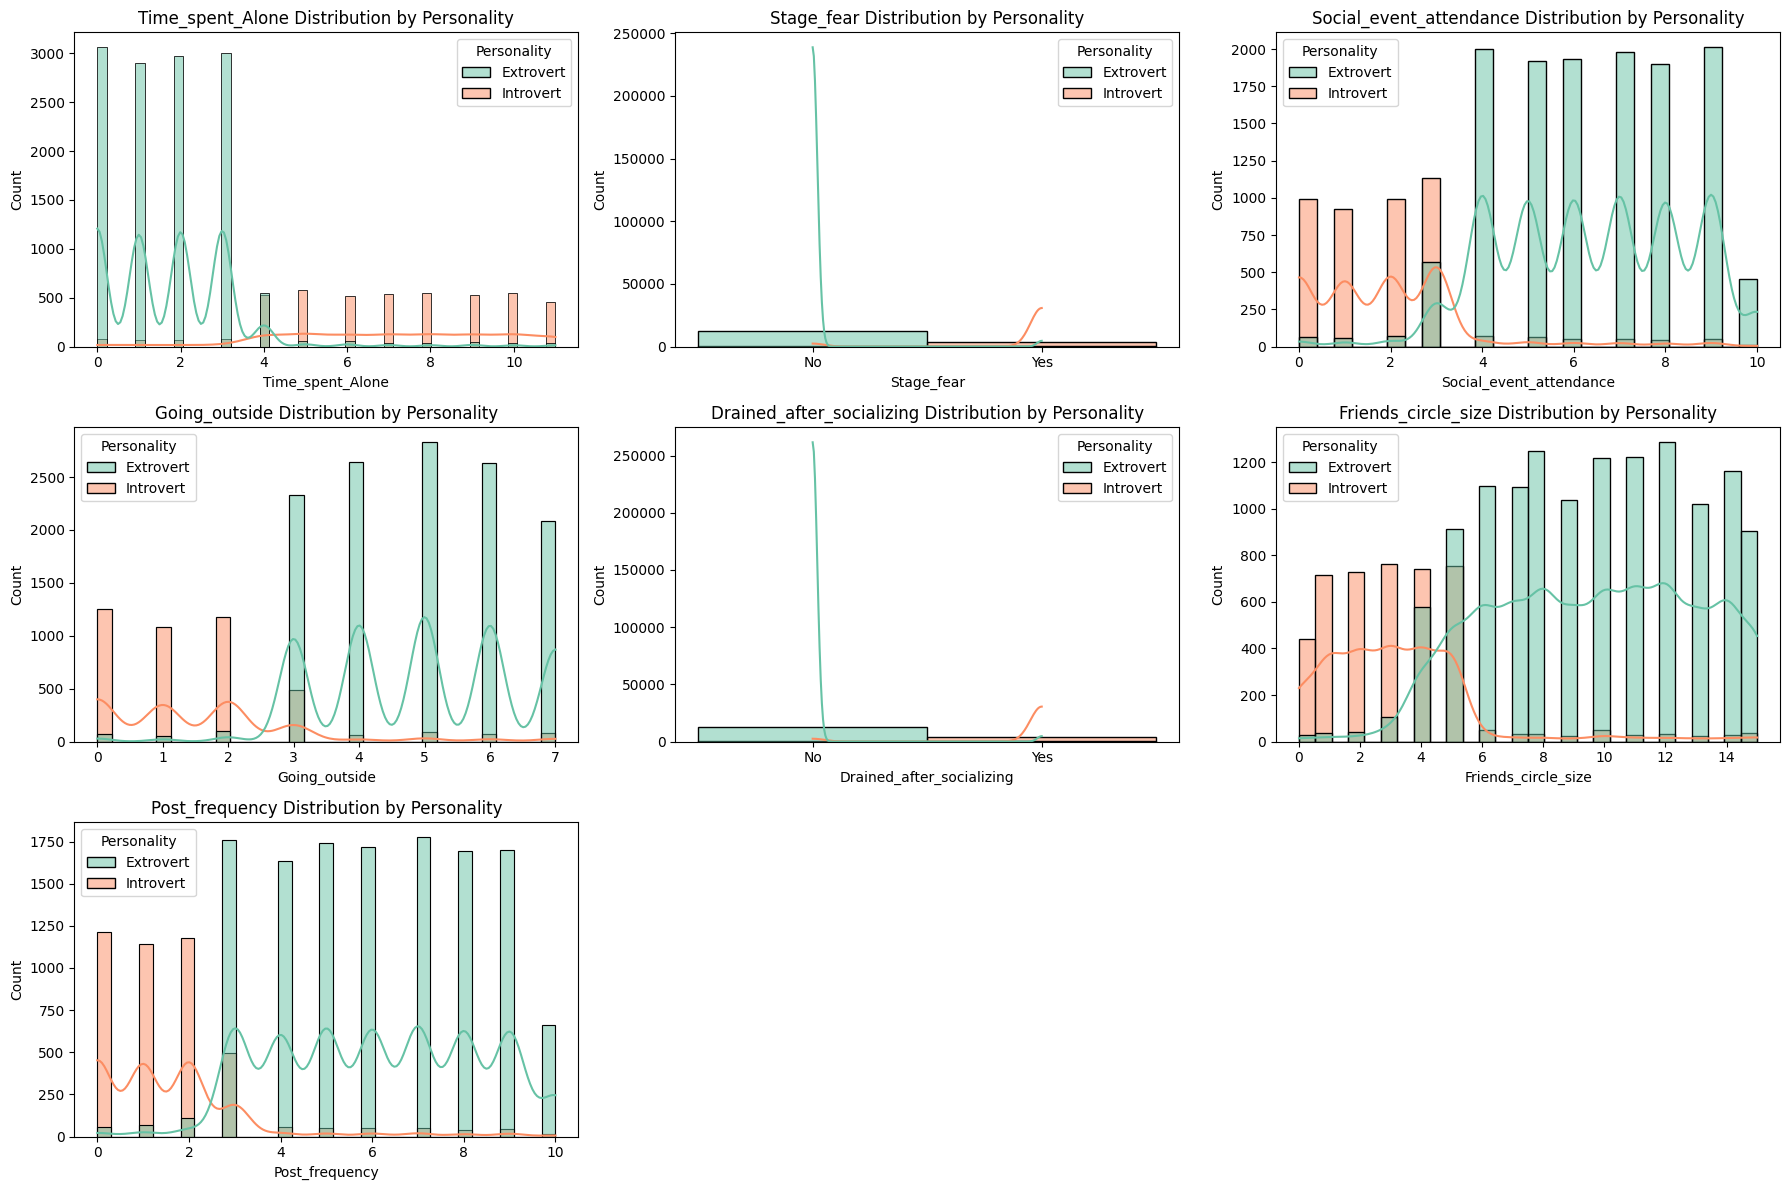

In [6]:
import math

# Number of features
features = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
            'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency']

n_features = len(features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axs = axs.flatten()  # Flatten the axes array for easy indexing

for i, col in enumerate(features):
    sns.histplot(data=train, x=col, hue='Personality', kde=True, ax=axs[i], palette='Set2')
    axs[i].set_title(f'{col} Distribution by Personality')

# Remove unused subplots if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [7]:
# Create a copy of the training data to work with
df = train.copy()

# Now check missing values
missing_info = df.isnull().sum()
print("Missing values:\n", missing_info[missing_info > 0])

Missing values:
 Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
dtype: int64


In [8]:
df['Friends_circle_size'].fillna(df['Friends_circle_size'].median(), inplace=True)

In [9]:
binary_map = {'Yes': 1, 'No': 0}
df['Stage_fear'] = df['Stage_fear'].map(binary_map)
df['Drained_after_socializing'] = df['Drained_after_socializing'].map(binary_map)
df['target'] = df['Personality'].map({'Introvert': 0, 'Extrovert': 1})

test['Stage_fear'] = test['Stage_fear'].map(binary_map)
test['Drained_after_socializing'] = test['Drained_after_socializing'].map(binary_map)
test['Friends_circle_size'].fillna(df['Friends_circle_size'].median(), inplace=True)

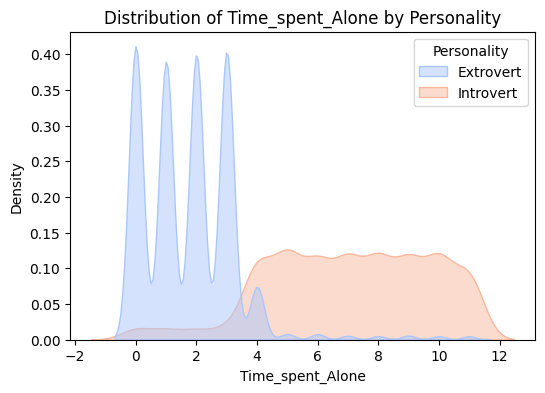

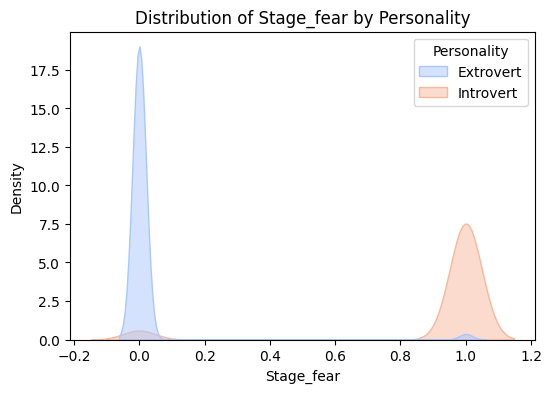

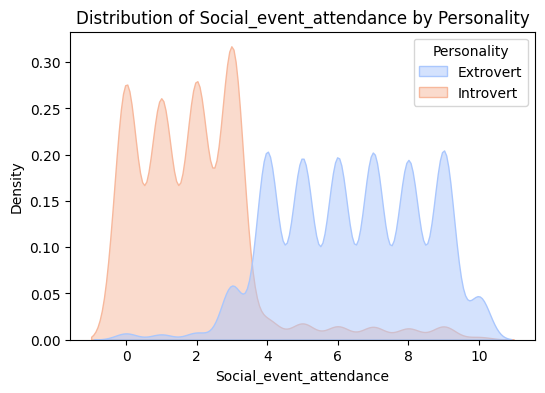

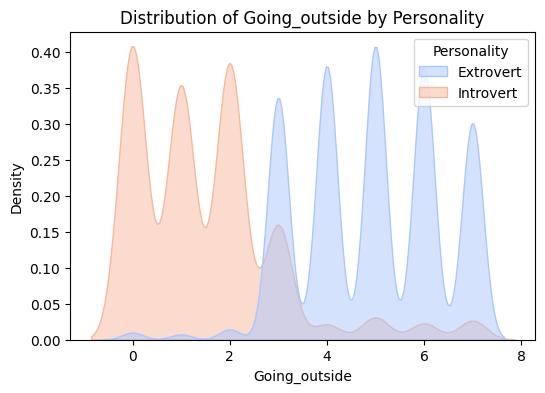

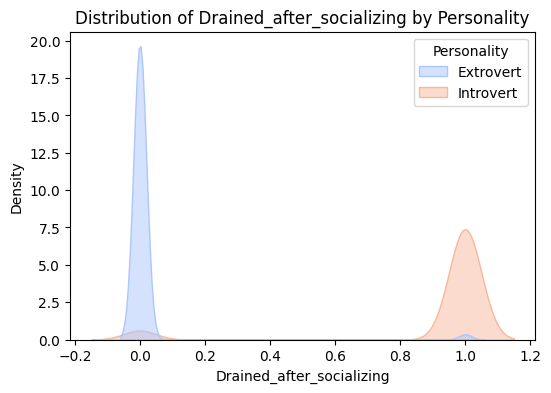

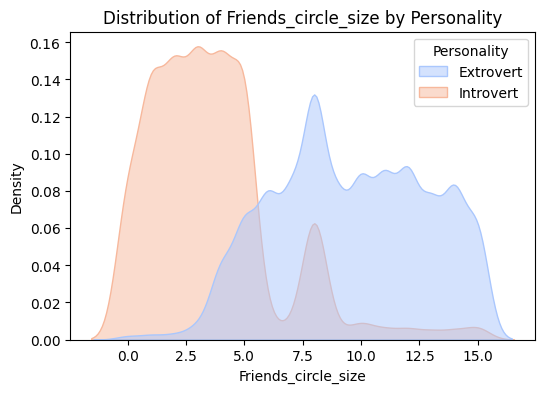

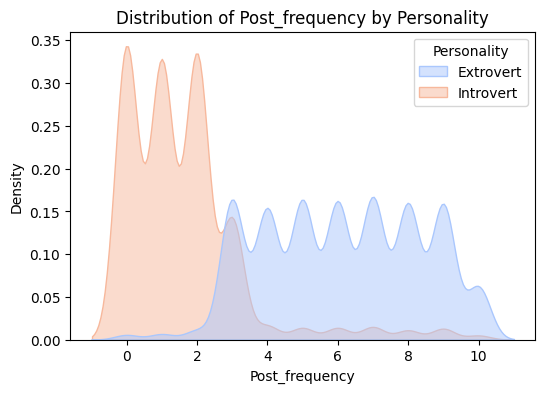

In [10]:
features = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
            'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency']

for col in features:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df, x=col, hue='Personality', fill=True, common_norm=False, palette='coolwarm', alpha=0.5)
    plt.title(f'Distribution of {col} by Personality')
    plt.show()

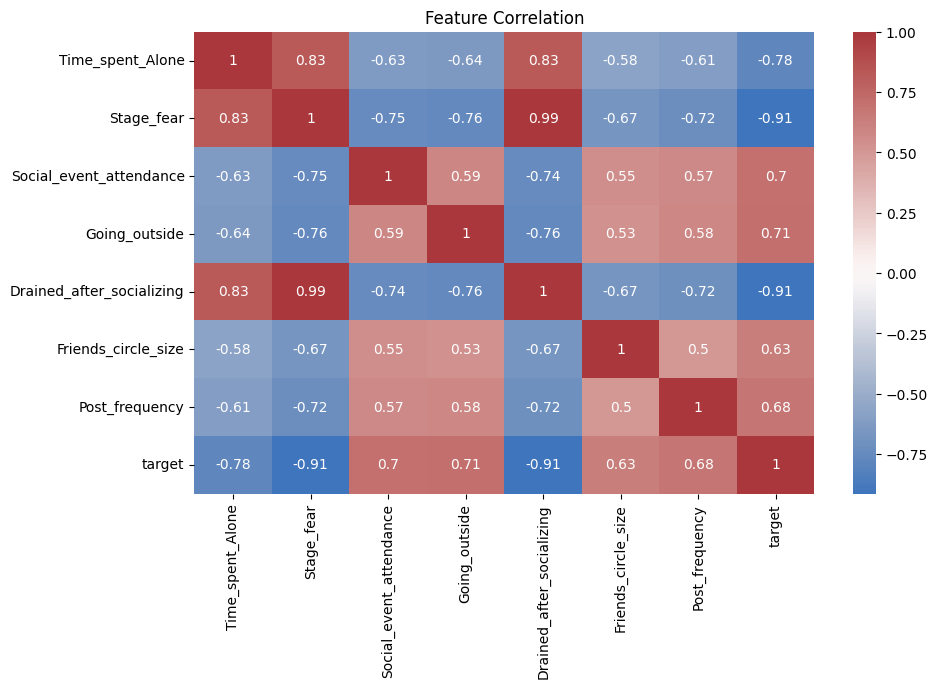

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[features + ['target']].corr(), annot=True, cmap='vlag', center=0)
plt.title("Feature Correlation")
plt.show()

In [12]:
# Ensure no missing values in features used
df[features] = df[features].fillna(df[features].median())

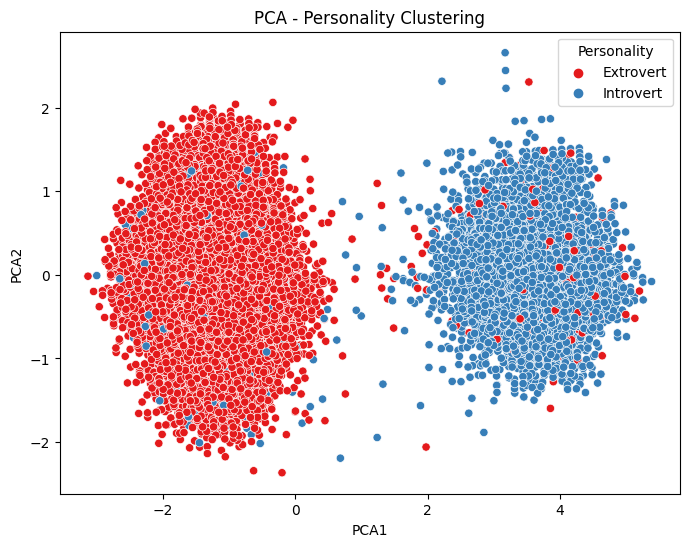

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(df[features])
pca = PCA(n_components=2)
df[['PCA1', 'PCA2']] = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Personality', palette='Set1')
plt.title("PCA - Personality Clustering")
plt.show()

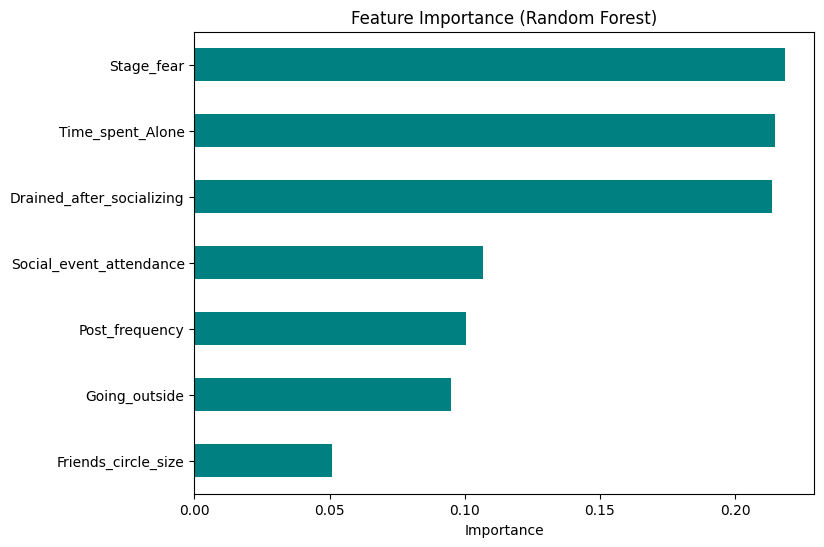

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(df[features], df['target'])

feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)
plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh', color='teal')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
df = train.copy()
test_df = test.copy()

binary_map = {'Yes': 1, 'No': 0}
df['Stage_fear'] = df['Stage_fear'].map(binary_map)
df['Drained_after_socializing'] = df['Drained_after_socializing'].map(binary_map)
df['target'] = df['Personality'].map({'Introvert': 0, 'Extrovert': 1})

test_df['Stage_fear'] = test_df['Stage_fear'].map(binary_map)
test_df['Drained_after_socializing'] = test_df['Drained_after_socializing'].map(binary_map)

# Fill missing values
df['Friends_circle_size'].fillna(df['Friends_circle_size'].median(), inplace=True)
test_df['Friends_circle_size'].fillna(df['Friends_circle_size'].median(), inplace=True)

# Final feature list
features = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
            'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency']

X = df[features]
y = df['target']
X_test = test_df[features]

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [17]:
imputer = IterativeImputer(max_iter=12, random_state=42, initial_strategy='median')

X = pd.DataFrame(imputer.fit_transform(X), columns=features)
X_test = pd.DataFrame(imputer.transform(X_test), columns=features)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print("Random Forest CV Accuracy:", rf_scores.mean())

# Fit and predict
rf.fit(X, y)
rf_preds = rf.predict(X_test)

Random Forest CV Accuracy: 0.9668540557241251


In [19]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_scores = cross_val_score(xgb, X, y, cv=5, scoring='accuracy')
print("XGBoost CV Accuracy:", xgb_scores.mean())

# Fit and predict
xgb.fit(X, y)
xgb_preds = xgb.predict(X_test)

XGBoost CV Accuracy: 0.9679337652987762


In [20]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier


base_lgbm = LGBMClassifier(random_state=42)
calibrated_model = CalibratedClassifierCV(base_lgbm, method='sigmoid', cv=5)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(calibrated_model, X, y, cv=skf, scoring='accuracy')
print("StratifiedKFold + CalibratedClassifierCV Accuracy:", cv_scores.mean())


[LightGBM] [Info] Number of positive: 8767, number of negative: 3088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1546
[LightGBM] [Info] Number of data points in the train set: 11855, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.739519 -> initscore=1.043471
[LightGBM] [Info] Start training from score 1.043471
[LightGBM] [Info] Number of positive: 8767, number of negative: 3088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1546
[LightGBM] [Info] Number of data points in the train set: 11855, number of used features: 7
[LightGBM] [Info] [binary:

In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

# Encode categorical columns
combined = pd.concat([train, test], axis=0)
label_encoders = {}

for col in combined.select_dtypes(include='object').columns:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col].astype(str))
    label_encoders[col] = le

train_encoded = combined.iloc[:len(train)].copy()
test_encoded = combined.iloc[len(train):].copy()

# Split features and target
X = train_encoded.drop(columns=['Personality'])
y = train_encoded['Personality']

# Train final model (use best parameters if you have them)
model = LGBMClassifier(
    n_estimators=590,
    learning_rate=0.03142122584812477,
    max_depth=5,
    num_leaves=31,
    min_child_samples=44,
    subsample=0.7408895172334935,
    colsample_bytree=0.8834838134615708,
    reg_alpha=8.382280639418514,
    reg_lambda=0.33032725414186936,
    random_state=42
)

model.fit(X, y)

# Predict on test set
test_preds = model.predict(test_encoded.drop(columns=['Personality'], errors='ignore'))

# Create submission file
submission = pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')
submission['Personality'] = test_preds
submission.to_csv('submission.csv', index=False)

print("✅ submission.csv saved successfully!")


[LightGBM] [Info] Number of positive: 4825, number of negative: 13699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 18524, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260473 -> initscore=-1.043512
[LightGBM] [Info] Start training from score -1.043512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 